In [1]:
%matplotlib inline

# Review optimization changes

- avoid appending to data frames in loops
- use scalar indexing shortcut (`.at` or `.loc`) when getting a value from a pandas series
- where possible (merch and gross volume), make functions work with numpy arrays instead of using loop/pandas apply
- use cython for functions that are called many thousands of times

# Compare Time of Original vs Optimized

``` bash
git checkout -b optimized-final 6136aa46d1dcb8e96f3d3efc95a897664d54829e
time gypsy simulate ../private-data/1000-plots.csv_prepped.csv -o gypsy-output-optimized
mv gypsy.log gypsy-output-optimized/
```

```
real	15m24.689s
user	15m4.180s
sys 	0m4.110s
```

``` bash
git checkout -b original-speed f0f8c61ef19c448e95d19e08df3d07b8728d58ac
time gypsy simulate ../private-data/1000-plots.csv_prepped.csv -o gypsy-output-original-speed
mv gypsy.log gypsy-output-original-speed/
```

```
real	69m57.357s
user	92m21.800s
sys 	0m8.440s
```

4 times faster, I had hoped for more. Alas.

# Compare Plot Duration Distribution of Original vs Optimized

In [5]:
import re
import numpy as np
import pandas as pd
from matplotlib import pyplot

def build_duration_table(log_filepath):
    pattern = '^.*plot (.*) took (.*) seconds$'
    rec = re.compile(pattern)
    matches = [rec.match(line) for line in open(log_filepath, 'r') if rec.match(line) is not None]
    times = [m.group(1,2) for m in matches]
    times_df = pd.DataFrame(times, columns=['PlotID', 'duration'])
    times_df['PlotID'] = times_df['PlotID'].astype(int)
    times_df['duration'] = times_df['duration'].astype(float)
    return times_df

In [14]:
times_opt = build_duration_table('gypsy-output-optimized/gypsy.log')
times_orig = build_duration_table('gypsy-output-original-speed/gypsy.log')
times = pd.merge(times_orig, times_opt, on='PlotID', suffixes=('original', 'optimized'))

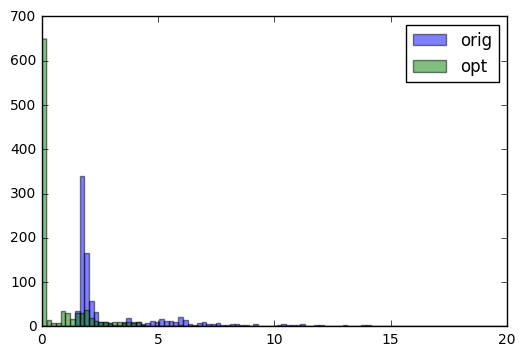

In [29]:
bins = np.linspace(0, 20, 100)
pyplot.hist(times['durationoriginal'], bins, alpha=0.5, label='orig')
pyplot.hist(times['durationoptimized'], bins, alpha=0.5, label='opt')
pyplot.legend(loc='upper right')
pyplot.show()

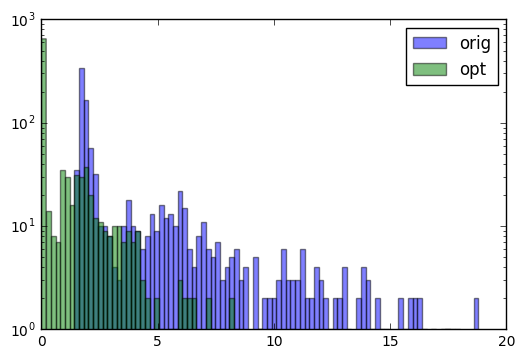

In [28]:
bins = np.linspace(0, 20, 100)
pyplot.hist(times['durationoriginal'], bins, alpha=0.5, label='orig')
pyplot.hist(times['durationoptimized'], bins, alpha=0.5, label='opt')
pyplot.legend(loc='upper right')
pyplot.yscale('log')
pyplot.show()

The distribution has simply been compressed, many more are now simulated in 'web time' - i.e. a couple hundred ms.